# Load the pred_T file and the gold file

In [1]:
pred_file = 'analysis/predT_not_in_original_pmid_predTs.json'
gold_file = 'data/KD-DTI/raw/test.json'

In [2]:
import json

# load the pmids that the pred_Ts are not in the original articles
with open (pred_file, 'r') as f:
    pred_d_not_in_original = json.load(f)

print(len(pred_d_not_in_original))
print(pred_d_not_in_original[0])

823
{'id': '11169165', 'predT_not_in_original': ['monoamine oxidase type b (mao-b)', 'monoamine oxidase type a (mao-a)']}


In [3]:
# load the gold standard
with open (gold_file, 'r') as f:
    gold_d = json.load(f)

print(len(gold_d))
print(gold_d[pred_d_not_in_original[0]['id']])

1159
{'title': 'Inhibition of rat brain monoamine oxidase activities by psoralen and isopsoralen: implications for the treatment of affective disorders.', 'abstract': 'Psoralen and isopsoralen, furocoumarins isolated from the plant Psoralea corylifolia L., were demonstrated to exhibit in vitro inhibitory actions on monoamine oxidase (MAO) activities in rat brain mitochondria, preferentially inhibiting MAO-A activity over MAO-B activity. This inhibition of enzyme activities was found to be dose-dependent and reversible. For MAO-A, the IC50 values are 15.2 +/- 1.3 microM psoralen and 9.0 +/- 0.6 microM isopsoralen. For MAO-B, the IC50 values are 61.8 +/- 4.3 microM psoralen and 12.8 +/- 0.5 microM isopsoralen. Lineweaver-Burk transformation of the inhibition data indicates that inhibition by both psoralen and isopsoralen is non-competitive for MAO-A. The Ki values were calculated to be 14.0 microM for psoralen and 6.5 microM for isopsoralen. On the other hand, inhibition by both psoralen

# Load the model

In [4]:
import torch
from src.transformer_lm_prompt import TransformerLanguageModelPrompt
m = TransformerLanguageModelPrompt.from_pretrained(
        "checkpoints/RE-DTI-BioGPT", 
        "checkpoint_avg.pt", 
        "data/KD-DTI/relis-bin",
        tokenizer='moses', 
        bpe='fastbpe', 
        bpe_codes="data/bpecodes",
        max_len_b=1024,
        beam=5)
m.cuda()

/home/tian/mambaforge/envs/BioGPT/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-11 18:18:19 | INFO | fairseq.file_utils | loading archive file checkpoints/RE-DTI-BioGPT
2023-04-11 18:18:19 | INFO | fairseq.file_utils | loading archive file data/KD-DTI/relis-bin
2023-04-11 18:18:20 | INFO | src.language_modeling_prompt | dictionary: 42384 types
2023-04-11 18:18:23 | INFO | fairseq.models.fairseq_model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': No

GeneratorHubInterface(
  (models): ModuleList(
    (0): TransformerLanguageModelPrompt(
      (decoder): TransformerDecoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(42393, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layers): ModuleList(
          (0): TransformerDecoderLayerBase(
            (dropout_module): FairseqDropout()
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (activation_dropout_module): FairseqDropout()
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine

In [128]:
# because it's hard to use the moses tokenizer.decode() to show the different between the 4 (= 4#) and 4</w>
# so here using the tokenizer from HF to decode each generated token, and it doesn't include the learn0 - learn9, which is not a problem
from transformers import BioGptTokenizer

tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")

# inference step by step

In [151]:
# a test data: {"pmid": ,
#               "id": ,
#               "title+abstract.lower()": ,
#               "text_tokens": ,
#               "pred_Ts": ,
#              "pred_Ts_tokens": ,}
#               "gold_triples": ,}

def get_test_data(id):
    prefix = torch.arange(42384, 42393)
    test_data = {}
    test_data['pmid'] = pred_d_not_in_original[id]['id']
    test_data['text'] = gold_d[test_data['pmid']]['title'].strip() + " " + gold_d[test_data['pmid']]['abstract']
    test_data['text'] = test_data['text'].lower().strip().replace('  ', ' ')
    test_data['text_tokens'] = m.encode(test_data['text'])
    test_data['text_tokens_with_prefix'] = torch.cat([test_data['text_tokens'], prefix], dim=-1).unsqueeze(0).cuda()
    test_data['pred_Ts'] = pred_d_not_in_original[id]['predT_not_in_original']
    test_data['pred_Ts_tokens'] = [m.encode(pred_T) for pred_T in test_data['pred_Ts']]
    test_data['gold_triples'] = gold_d[test_data['pmid']]['triples']
    return test_data

In [179]:
test_data = get_test_data(18)

print(f'"pred_Ds": "{test_data["pred_Ts"][0]}",')
print(f'"gold": {test_data["gold_triples"][0]},')
print(f'"text": "{test_data["text"]}"')

"pred_Ds": "nitric-oxide synthase inducible (nos2)",
"gold": {'drug': '3-Bromo-1H-indazole-7-carbonitrile', 'target': 'Nitric-oxide synthase brain (NOS1)', 'interaction': 'inhibitor'},
"text": "inhibitory effects of a series of 7-substituted-indazoles toward nitric oxide synthases: particular potency of 1h-indazole-7-carbonitrile. a series of new 7-monosubstituted and 3,7-disubstituted indazoles have been prepared and evaluated as inhibitors of nitric oxide synthases (nos). 1h-indazole-7-carbonitrile (6) was found equipotent to 7-nitro-1h-indazole (1) and demonstrated preference for constitutive nos over inducible nos. by contrast, 1h-indazole-7-carboxamide (8) was slightly less potent but demonstrated a surprising selectivity for the neuronal nos. further substitution of 6 by a br-atom at carbon-3 of the heterocycle enhanced 10-fold the inhibitory effects. inhibition of no formation by 6 appeared to be competitive versus both substrate and the cofactor (6r)-5,6,7,8-tetrahydro-l-biopte

In [173]:
prefix = torch.arange(42384, 42393)
texts = "xanthine derivatives ibmx and s-7799-2 potentiate transmission at an aplysia central cholinergic synapse. in an attempt to investigate the role of camp-dependent phosphorylations on synaptic transmission at an aplysia cholinergic buccal ganglion synapse, the effects of xanthine derivatives such as 3-isobutyl-1-methylxanthine (ibmx), which is well known to inhibit phosphodiesterase activity thereby promoting camp accumulation, and a novel xanthine derivative, s-7799-2 were evaluated. they were found to potentiate cholinergic transmission by significantly increasing the time constant of decay (tc) of inhibitory postsynaptic currents (ipscs). the postsynaptic origin of the phenomenon was supported by the observation that responses to the ionophoretic application of acetylcholine (ach) were also potentiated in duration as well as in amplitude. no effects of s-7799-2 on the ach-gated cl- channel conductance or mean open time were observed. the finding that responses to the hydrolysis-resistant cholinergic analogue carbachol were unaffected by the two xanthines suggested that the observed effects were at least partly caused by an inhibition of acetylcholinesterase (ache) activity. that these substances inhibit ache activity was confirmed in vitro. phosphorylation processes nonetheless appear to be partly involved in the synaptic effect of the xanthines as the kinase blocker h-8 blocked part of the ipsc tc lengthening. possible mechanisms are discussed."
tokens = m.encode(texts)
test_dataa = torch.cat([tokens, prefix], dim=-1).unsqueeze(0).cuda()
for token_id in test_dataa[0]:
    print(f'"{token_id.item()}": "{tokenizer.convert_ids_to_tokens([token_id])[0]}",')

"10130": "xanthine</w>",
"2025": "derivatives</w>",
"2898": "ib",
"676": "m",
"543": "x</w>",
"8": "and</w>",
"279": "s</w>",
"9": "@-@</w>",
"11770": "77",
"2404": "99</w>",
"9": "@-@</w>",
"40": "2</w>",
"16227": "potentiate</w>",
"1323": "transmission</w>",
"34": "at</w>",
"32": "an</w>",
"806": "a",
"2234": "pl",
"39074": "ysia</w>",
"698": "central</w>",
"4961": "cholinergic</w>",
"13988": "synap",
"3265": "se",
"4": ".</w>",
"10": "in</w>",
"32": "an</w>",
"3662": "attempt</w>",
"13": "to</w>",
"559": "investigate</w>",
"6": "the</w>",
"151": "role</w>",
"5": "of</w>",
"8490": "cam",
"110": "p</w>",
"9": "@-@</w>",
"267": "dependent</w>",
"21498": "phosphoryl",
"1184": "ations</w>",
"25": "on</w>",
"2483": "synaptic</w>",
"1323": "transmission</w>",
"34": "at</w>",
"32": "an</w>",
"806": "a",
"2234": "pl",
"39074": "ysia</w>",
"4961": "cholinergic</w>",
"10077": "buccal</w>",
"4824": "ganglion</w>",
"12508": "synapse</w>",
"7": ",</w>",
"6": "the</w>",
"92": "effects</w>",
"5": "

In [180]:
for token_id in test_data['text_tokens_with_prefix'][0]:
    print(f'"{token_id.item()}": "{tokenizer.convert_ids_to_tokens([token_id])[0]}",')

"1166": "inhibitory</w>",
"92": "effects</w>",
"5": "of</w>",
"14": "a</w>",
"870": "series</w>",
"5": "of</w>",
"215": "7</w>",
"9": "@-@</w>",
"4225": "substituted</w>",
"9": "@-@</w>",
"5755": "ind",
"22572": "azoles</w>",
"1542": "toward</w>",
"2624": "nitric</w>",
"1279": "oxide</w>",
"26552": "synthases</w>",
"20": ":</w>",
"1034": "particular</w>",
"4051": "potency</w>",
"5": "of</w>",
"926": "1",
"259": "h</w>",
"9": "@-@</w>",
"5755": "ind",
"6633": "azole</w>",
"9": "@-@</w>",
"215": "7</w>",
"9": "@-@</w>",
"5319": "carb",
"36797": "onitr",
"1628": "il",
"36448": "e.</w>",
"14": "a</w>",
"870": "series</w>",
"5": "of</w>",
"176": "new</w>",
"215": "7</w>",
"9": "@-@</w>",
"14136": "monos",
"33448": "ubstituted</w>",
"8": "and</w>",
"4273": "3,",
"215": "7</w>",
"9": "@-@</w>",
"33361": "disubstituted</w>",
"5755": "ind",
"22572": "azoles</w>",
"47": "have</w>",
"58": "been</w>",
"1380": "prepared</w>",
"8": "and</w>",
"330": "evaluated</w>",
"27": "as</w>",
"891": "inhibitor

In [181]:
# initialize
test_input = test_data['text_tokens_with_prefix']

output_text = []
k = 5
prob = []
ranking = []
step = 0

with torch.no_grad():
    m.models[0].decoder.eval()
    step += 1

    out = m.models[0].decoder(test_input)

    softmax_out = torch.softmax(out[0][0][-1], dim=-1)
    _, top_k_indices = torch.topk(out[0][0][-1], k=k)
    top_k_tokens = [tokenizer.convert_ids_to_tokens([indice]) for indice in top_k_indices]
    top_k_probs = torch.softmax(out[0][0][-1][top_k_indices], dim=-1)
    top_k = [(token, prob.item()) for token, prob in zip(top_k_tokens, top_k_probs)]
    print(f'The top-{k} most possible tokens are:\n{top_k}')
    next_token_id = int(input('Please input the next token:'))
    test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
    output_text.append(top_k_indices[next_token_id-1])

    prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
    ranking.append(next_token_id)
    while (next_token_id != 0):        
        print(f'output_text: {m.decode(output_text)}\n')
        step += 1

        out = m.models[0].decoder(test_input)
        softmax_out = torch.softmax(out[0][0][-1], dim=-1)
        _, top_k_indices = torch.topk(out[0][0][-1], k=k)
        top_k_tokens = [tokenizer.convert_ids_to_tokens([indice]) for indice in top_k_indices]
        top_k_probs = torch.softmax(out[0][0][-1][top_k_indices], dim=-1)
        top_k = [(token, prob.item()) for token, prob in zip(top_k_tokens, top_k_probs)]
        print(f'The top-{k} most possible tokens are:\n{top_k}')
        next_token_id = int(input('Please input the next token (0 to end, -1 to input Customized string):'))
        if next_token_id == 0:
            break
        if next_token_id == -1:
            customized_string = input('Please input the Customized string:')
            customized_string_tokens = torch.tensor(tokenizer.convert_tokens_to_ids(customized_string)).unsqueeze(0).cuda()
            test_input = torch.cat([test_input[0], customized_string_tokens], dim=-1).unsqueeze(0)
            output_text.append(customized_string_tokens.squeeze(0))

            customized_string_prob = out[0][0][-1][customized_string_tokens].clone()
            sorted_output, _ = torch.sort(out[0][0][-1], descending=True)
            print(f'The {customized_string} has the {torch.where(sorted_output == customized_string_prob)[0].item() + 1} / {len(sorted_output)} biggest probability in output.')
            
            prob.append(softmax_out[customized_string_tokens].item())
            ranking.append(torch.where(sorted_output == customized_string_prob)[0].item() + 1)

            continue
        if next_token_id != 1:
            print(f'The token has the {next_token_id} / {len(sorted_output)} biggest probability in output.')
        test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
        output_text.append(top_k_indices[next_token_id-1])

        prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
        ranking.append(next_token_id)


The top-5 most possible tokens are:
[(['the</w>'], 0.9999977350234985), (['<unk>'], 7.513795026170556e-07), (['an</w>'], 6.147940894152271e-07), (['<unk>'], 5.747674549638759e-07), (['their</w>'], 4.162162952070503e-07)]
output_text: the

The top-5 most possible tokens are:
[(['interaction</w>'], 0.9999583959579468), (['interactions</w>'], 3.52180541085545e-05), (['interacting</w>'], 2.646220082169748e-06), (['association</w>'], 2.0857401068496983e-06), (['relationship</w>'], 1.6648806422381313e-06)]
output_text: the interaction

The top-5 most possible tokens are:
[(['between</w>'], 0.9999723434448242), (['of</w>'], 2.2286027160589583e-05), (['with</w>'], 2.8870240385003854e-06), (['is</w>'], 1.272347390113282e-06), (['(</w>'], 1.2038821068927064e-06)]
output_text: the interaction between

The top-5 most possible tokens are:
[(['7</w>'], 0.2845838963985443), (['1'], 0.21450771391391754), (['n'], 0.18082371354103088), (['l</w>'], 0.1680757701396942), (['1-</w>'], 0.15200898051261902)]


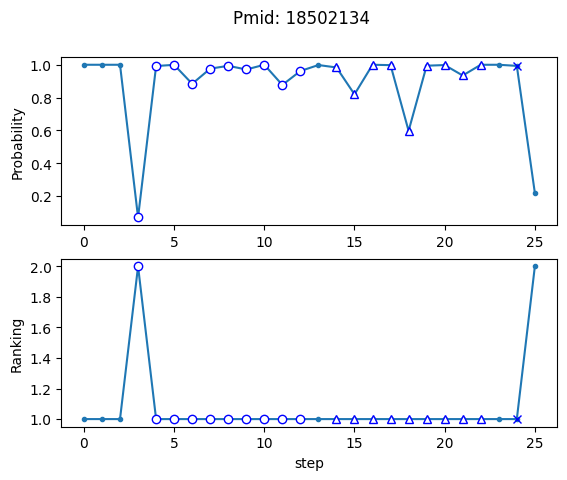

In [182]:
import numpy as np
import matplotlib.pyplot as plt

# Create some fake data.
x = np.arange(step-1)
y1 = prob
y2 = ranking

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle(f'Pmid: {test_data["pmid"]}')

ax1.plot(x, y1, '.-')
ax1.set_ylabel('Probability')

ax2.plot(x, y2, '.-')
ax2.set_xlabel('step')
ax2.set_ylabel('Ranking')

marks = [0]* (step-1)
mark = False

# 0 for  parttern tokens, 1 for drugs ,2 for targets, 3 for interaction
for i, token in enumerate(output_text):
    if token != 6 and output_text[i-1] == 45:
        marks[i] = 1
        mark = True
        continue
    if token == 8 or token == 21 or token == 4:
        continue
    if token != 6 and output_text[i-1] == 8:
        marks[i] = 2
        mark = True
        continue
    if token != 6 and output_text[i-1] == 21:
        marks[i] = 3
        mark = True
        continue
    if token == 44:
        mark = False
        continue
    if mark:
        marks[i] = marks[i-1]
        

# if marks[x] == 1, then using hollow circle for the plot, if marks[x] == 2, then using hollow triangle for the plot, if marks[x] == 3, then using star for the plot.
for i in range(step-1):
    if marks[i] == 1:
        ax1.plot(x[i], y1[i], marker='o', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='o', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='o', color='white', markeredgecolor='red')
            ax2.plot(x[i], y2[i], marker='o', color='white', markeredgecolor='red')

    if marks[i] == 2:
        ax1.plot(x[i], y1[i], marker='^', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='^', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='^', color='red')
            ax2.plot(x[i], y2[i], marker='^', color='red')

    if marks[i] == 3:
        ax1.plot(x[i], y1[i], marker='x', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='x', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='x', color='red')
            ax2.plot(x[i], y2[i], marker='x', color='red')


plt.savefig(f'analysis/img/{test_data["pmid"]}.png')
plt.show()